In [1]:
import torch
import torch
from torch.nn import functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

from palindrome import check_palindrome
from tracr.haiku_to_pytorch import haiku_to_pytorch, apply

from dataloaders import makePalindromeDataLoader

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def evaluate(model, data):
    inputs, outputs = data[0]

    model_output = model.forward(inputs)

    loss = F.cross_entropy(model_output, outputs)
    if torch.isnan(loss) or torch.isinf(loss):
        print(inputs)
        print(model_output)
        print(outputs)
        print(loss)
    return loss, {
        "logits": model_output
    }

In [ ]:
loader = makePalindromeDataLoader()

[(['BOS', 'j', 'k', 'j'], tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], dtype=torch.float64))]


In [5]:
model = check_palindrome()
torch_model = haiku_to_pytorch(model)

In [28]:
learning_coeff_stats = estimate_learning_coeff_with_summary(
    torch_model,
    loader=loader,
    evaluate=evaluate,
    sampling_method=SGLD,
    optimizer_kwargs=dict(lr=4e-4, localization=100.0, nbeta=default_nbeta(loader)),
    num_chains=3,  # How many independent chains to run
    num_draws=100,  # How many samples to draw per chain
    num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
    num_steps_bw_draws=1,  # How many steps to take between each sample
    device=DEVICE,
    online=True,
)

/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/utils.py:88: UserWarning: default nbeta is undefined for batch_size * grad_accum_steps == 1, falling back to default value of 1
  warnings.warn(
/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/slt/sampler.py:117: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:240: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinterp/backends/default/slt/sampler.py:285: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/home/wisp/anaconda3/envs/llc/lib/python3.10/site-packages/devinte

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]]], dtype=torch.float64,
       grad_fn=<AddBackward0>)
tensor([[[0.0000e+00, 0.0000e+00, 6.7440e-03,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.4168e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 1.4168e-04,  ..., 1.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 1.4168e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 4.0929e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 9.7913e-01,  ..., 1.0000e+00,
          0.0000e+00, 0.0000e+00]]], dtype=torch.float64)
tensor(nan, dtype=t

RuntimeError: NaN detected in loss at chain 0, draw 43

In [26]:
trace = learning_coeff_stats["loss/trace"]

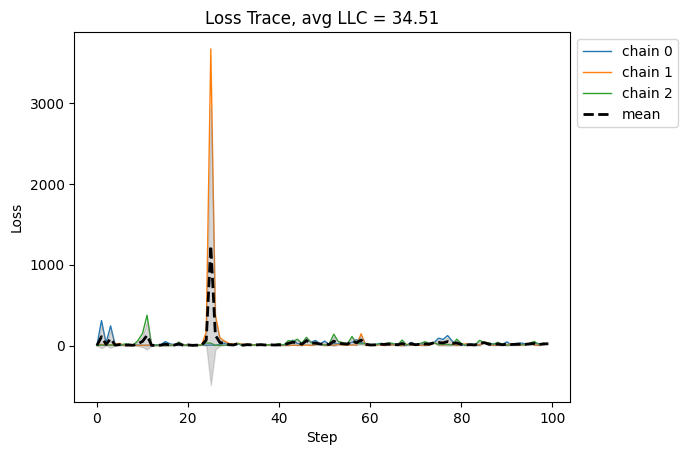

<Figure size 1200x900 with 0 Axes>

In [27]:
plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)